## Model Tuning - Hyperparameters Optimization:

Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose.





<img src="./images/model_tuning.png" width="700" height="700">



### Tuning The Model - Hyperparameter Optimization (HPO)

![HPO](./images/gif.gif "HPO Experiment")

![HPO](./images/Optimized_Controller.gif "HPO Experiment")


**Source: ** http://arxiv.org/abs/1509.01066 and https://www.youtube.com/watch?v=GiqNQdzc5TI


Hyperparameter tuning is a supervised machine learning regression problem. Given a set of input features (the hyperparameters), hyperparameter tuning optimizes a model for the metric that you choose. hyperparameter tuning makes guesses about which hyperparameter combinations are likely to get the best results, and runs training jobs to test these guesses.

## Restore variables from previous session

In [19]:
%store -r

## Define the hyperparameters ranges, estimator and tuning job

In [76]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
import boto3

role = sagemaker.get_execution_role()
sess = sagemaker.Session()
container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

hyperparameter_ranges = {
                        'min_child_weight': ContinuousParameter(1, 10),
                        'alpha': ContinuousParameter(0, 2),
                        'max_depth': IntegerParameter(3, 5)
                        }

objective_metric_name = 'validation:error'


xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)

xgb.set_hyperparameters(early_stopping_rounds = 20, eta = 0.6229867514, num_round = 150)

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10,
                            objective_type='Minimize',
                            max_parallel_jobs=3)

tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, include_cls_metadata=False)

## Check the Hyperparameter Tuning Job Status

In [77]:
import time
response = ''
hpo_job_name = tuner.latest_tuning_job.name
while response != 'Completed':
    response = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(HyperParameterTuningJobName = hpo_job_name)['HyperParameterTuningJobStatus']
    print(response)
    time.sleep(20)

InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed


## Fetch all results as DataFrame
We can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric.

In [78]:
import pandas as pd

tuning_job_name = tuner.latest_tuning_job.name
sage_client = boto3.client('sagemaker')
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')

tuner_jobs = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_jobs.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df


Number of training jobs with valid objective: 10
{'lowest': 0.06599000096321106, 'highest': 0.10152299702167511}


,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,alpha,max_depth,min_child_weight
3,0.065990,57.0,2019-10-20 12:00:19+00:00,sagemaker-xgboost-191020-1150-007-9b841417,Completed,2019-10-20 11:59:22+00:00,0.310008,5.0,1.521475
0,0.076142,56.0,2019-10-20 12:04:14+00:00,sagemaker-xgboost-191020-1150-010-02aca5fd,Completed,2019-10-20 12:03:18+00:00,0.625215,5.0,1.001353
2,0.086294,58.0,2019-10-20 12:00:39+00:00,sagemaker-xgboost-191020-1150-008-87cd8658,Completed,2019-10-20 11:59:41+00:00,0.037608,4.0,1.069568
4,0.086294,51.0,2019-10-20 11:57:22+00:00,sagemaker-xgboost-191020-1150-006-88445405,Completed,2019-10-20 11:56:31+00:00,0.420015,4.0,2.119312
7,0.086294,56.0,2019-10-20 11:53:40+00:00,sagemaker-xgboost-191020-1150-003-8fd19877,Completed,2019-10-20 11:52:44+00:00,0.387167,4.0,2.175553
1,0.091371,56.0,2019-10-20 12:00:38+00:00,sagemaker-xgboost-191020-1150-009-10abe8a8,Completed,2019-10-20 11:59:42+00:00,0.057608,4.0,1.159568
5,0.096447,87.0,2019-10-20 11:57:16+00:00,sagemaker-xgboost-191020-1150-005-8d4cbfbb,Completed,2019-10-20 11:55:49+00:00,0.404890,5.0,8.953182
6,0.096447,56.0,2019-10-20 11:56:43+00:00,sagemaker-xgboost-191020-1150-004-b914d245,Completed,2019-10-20 11:55:47+00:00,0.401866,5.0,8.953182
9,0.096447,55.0,2019-10-20 11:53:30+00:00,sagemaker-xgboost-191020-1150-001-3997fbd8,Completed,2019-10-20 11:52:35+00:00,1.705313,3.0,3.234886
8,0.101523,56.0,2019-10-20 11:53:47+00:00,sagemaker-xgboost-191020-1150-002-1ee6e0fd,Completed,2019-10-20 11:52:51+00:00,1.200340,5.0,8.696733


## See TuningJob results vs time
Next we will show how the objective metric changes over time, as the tuning job progresses. For Bayesian strategy, you should expect to see a general trend towards better results, but this progress will not be steady as the algorithm needs to balance exploration of new areas of parameter space against exploitation of known good areas. This can give you a sense of whether or not the number of training jobs is sufficient for the complexity of your search space.

In [79]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner_jobs)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

## Analyze the correlation between objective metric and individual hyperparameters
Now you have finished a tuning job, you may want to know the correlation between your objective metric and individual hyperparameters you've selected to tune. Having that insight will help you decide whether it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For example, if you see a positive trend between objective metric and a numerical hyperparameter, you probably want to set a higher tuning range for that hyperparameter in your next tuning job.

The following cell draws a graph for each hyperparameter to show its correlation with your objective metric.

In [80]:
ranges = tuner_jobs.tuning_ranges
figures = []

for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

## Deploy the best model from the HPO job

You can deploy the best model from the best training job directly by calling .deploy() from the tuner object

In [81]:
tuner.deploy(initial_instance_count=1,
                           instance_type='ml.m4.xlarge')

2019-10-20 12:00:19 Starting - Preparing the instances for training
2019-10-20 12:00:19 Downloading - Downloading input data
2019-10-20 12:00:19 Training - Training image download completed. Training in progress.
2019-10-20 12:00:19 Uploading - Uploading generated training model
2019-10-20 12:00:19 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:error to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[12:00:09] 688x30 matrix with 20640 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:De

KeyboardInterrupt: 

## Making a local inference request After Loading The Model

Get the model artifact from S3 Location then the unpack it and load it to use it for prediction.

In [70]:
# Download the model artifacts before running the next piece of code
best_job = tuner.best_training_job()
response = sage_client.describe_training_job(TrainingJobName= best_job)
model_artifacts = response['ModelArtifacts']['S3ModelArtifacts']
!aws s3 cp $model_artifacts ./model/
!tar -zxvf ./model/model.tar.gz -C ./model/

download: s3://sagemaker-us-east-1-625616379791/DEMO-xgboost-fraud-detection/output/sagemaker-xgboost-191020-1109-008-62c2a70e/output/model.tar.gz to model/model.tar.gz
xgboost-model


In [72]:
import pickle
import xgboost as xgb
import numpy as np
transaction= "-1.009630,0.141192,0.167167,-0.808785,2.112167,-1.294934,0.592454,-0.049872,-0.284882,-1.296757,-1.010293,-0.272631,-0.139809,-0.918097,-0.475136,0.519497,0.158822,-0.120745,-0.519128,0.108956,-0.225473,-0.947079,0.054725,0.368866,-0.158482,0.070904,0.022035,0.177674,-0.279746,0.391123"
test = transaction.split(',')
data = np.asarray(test).reshape((1,-1))
test_matrix = xgb.DMatrix(data)
filename = "./model/xgboost-model"
xgb_loaded = pickle.load(open(filename, 'rb'))
predictions = xgb_loaded.predict(test_matrix)
predictions[0]

0.064701825

## Interperting the Machine Learning Model

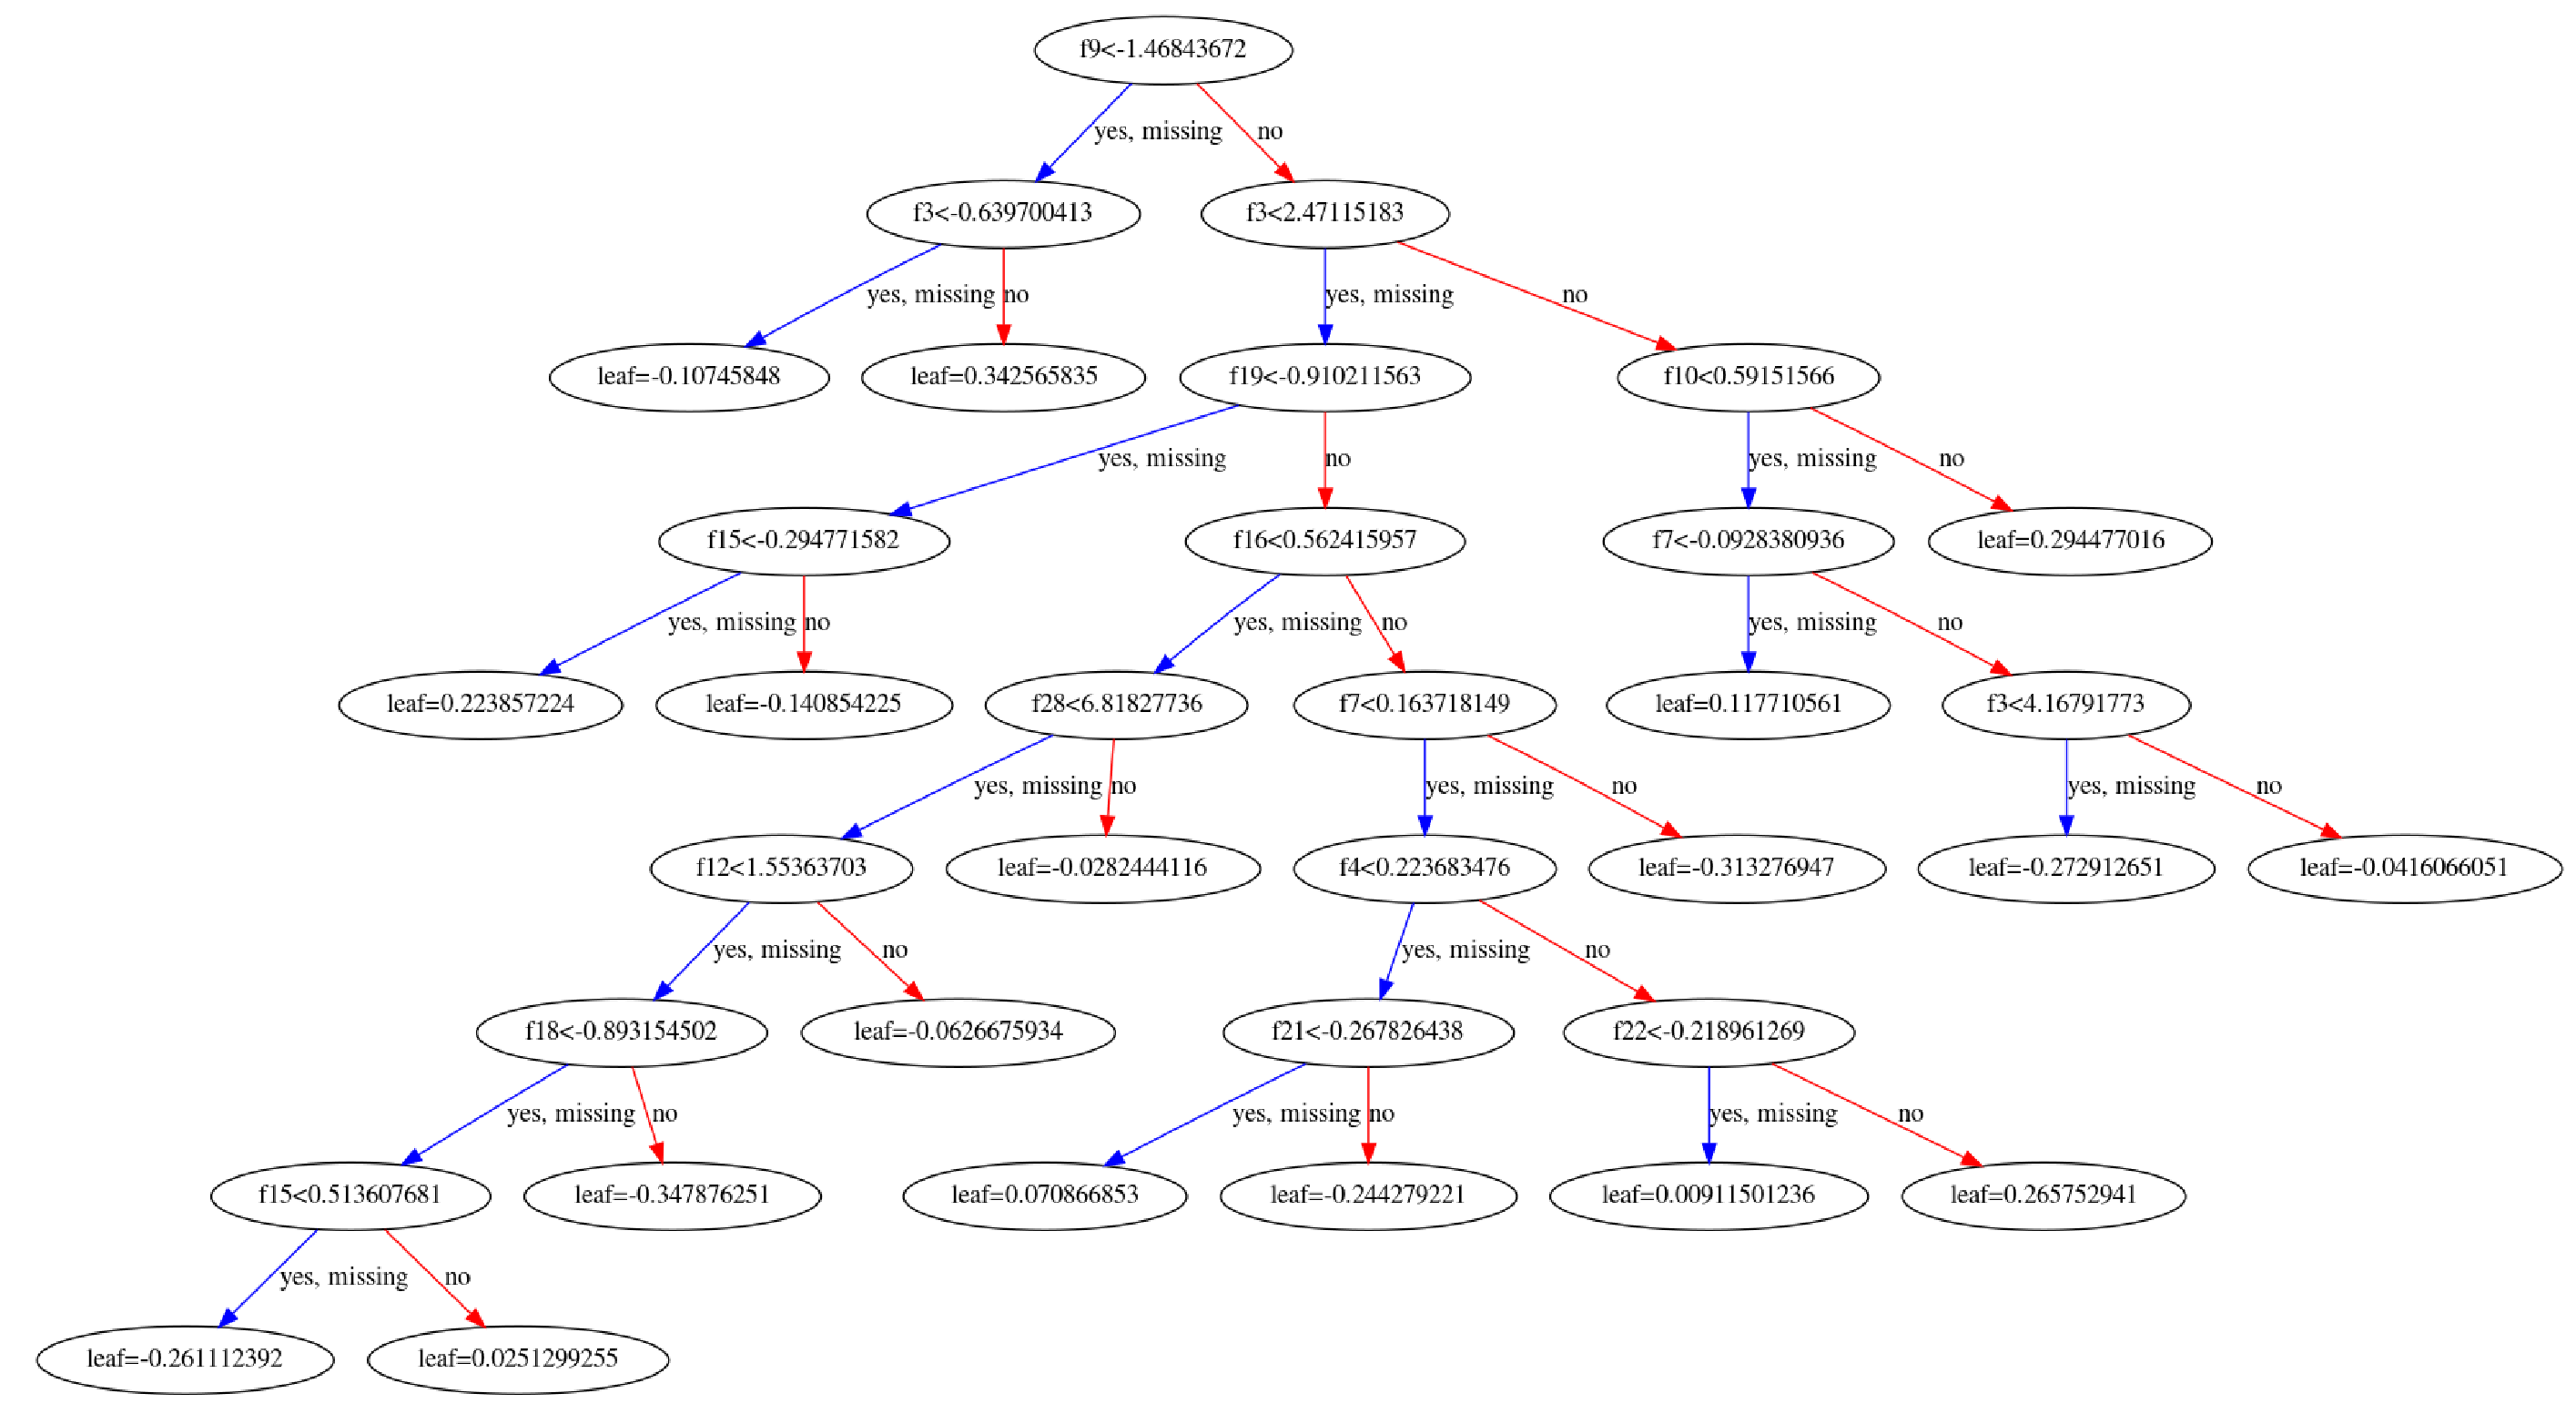

In [74]:
from xgboost import plot_tree, Booster
import xgboost as xgb
import matplotlib.pyplot as plt
import pickle as pkl
from xgboost import plot_tree, plot_importance
from matplotlib.pylab import rcParams

filename='./xgboost-model'
# plot single tree
rcParams['figure.figsize'] = 50,50
 
model = pkl.load(open(filename,'rb')) 
plot_tree(model, num_trees=4)
plt.show()

## Useful Resources:

- Amazon Sagemaker: https://docs.aws.amazon.com/sagemaker/latest/dg/whatis.html
- XGBoost Algorithm: https://xgboost.readthedocs.io/en/latest/
- Oversampling vs Undersampling: https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis
- Why Correlation Matters: https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4
- Correlation Matrix: https://en.wikipedia.org/wiki/Correlation_and_dependence#Correlation_matrices
- Hyperparameters Optimization: https://aws.amazon.com/blogs/aws/sagemaker-automatic-model-tuning/
